# Simulation: only surface velocities, four days, low tide

# Importing packages

In [20]:
import xarray as xr
import numpy as np
from datetime import timedelta
from parcels import FieldSet, ParticleSet, AdvectionRK4, JITParticle, plotTrajectoriesFile
import sys
sys.path.append("..")
import format_data
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cf

In [31]:
plt.style.use('seaborn-dark-palette')
plt.rcParams.update({'font.size': 18, 'figure.figsize': (12.8, 9.6)})
cmap = mpl.cm.get_cmap('viridis')

In [3]:
save_plots = True

# Empty map

In [4]:
def get_map():
    ax = plt.axes(projection=ccrs.PlateCarree())
    fig = plt.gcf()
    ax.set_extent([3.5,4.75,51.9,52.75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.LAND)
    ax.add_feature(cf.OCEAN)
    ax.add_feature(cf.RIVERS)
    ax.gridlines(draw_labels=True)
    
    return fig, ax

# Preprocessing data

In [5]:
data_dir = format_data.data_dir("../../Data")
uxg = data_dir.preprocess("uxg")
uyg = data_dir.preprocess("uyg")

In [6]:
surface_uxg = uxg.__xarray_dataarray_variable__[:,19,:,:]
surface_uyg = uyg.__xarray_dataarray_variable__[:,19,:,:]

**Masking velocities on land**

In [7]:
surface_uxg_clipped = data_dir.clip(surface_uxg)
surface_uyg_clipped = data_dir.clip(surface_uyg)

In [8]:
surface_ds = xr.Dataset({"U": surface_uxg_clipped, "V": surface_uyg_clipped})

# Initializing the field for Parcels

In [9]:
variables = {"U": "U", "V": "V"}
dimensions = {"U": {"lat": "lat", "lon": "lon", "time": "time"},
              "V": {"lat": "lat", "lon": "lon", "time": "time"}}

fieldset = FieldSet.from_xarray_dataset(ds=surface_ds, variables=variables, dimensions=dimensions)

# Number, locations and timesteps of particles

In [10]:
npart = 7 # 7 particles
lon = 4.075 * np.ones(npart) 
lat = 51.995 * np.ones(npart)
time = (np.arange(0, npart) * timedelta(minutes=20).total_seconds()) + timedelta(hours=1, minutes=10).total_seconds() # Drop particles at 20 minute interval after 15:00 at 17-09
output_dt = timedelta(minutes=5)

# Particle set

In [11]:
pset = ParticleSet(fieldset=fieldset,
                   pclass=JITParticle,
                   lon=lon,
                   lat=lat,
                   time=time)

In [12]:
output_file = pset.ParticleFile(name="surface_low_tide_output.nc",
                                outputdt=output_dt)

# Execute kernel

In [13]:
pset.execute(AdvectionRK4,
             runtime=timedelta(days=4),
             dt=output_dt,
             output_file=output_file)

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1000/df69d5ca54a73fbf35da5ab8438c7f7e_0.so
INFO: Temporary output files are stored in out-KOEGRJIQ.
INFO: You can use "parcels_convert_npydir_to_netcdf out-KOEGRJIQ" to convert these to a NetCDF file during the run.
100% (345600.0 of 345600.0) |############| Elapsed Time: 0:00:06 Time:  0:00:06


In [14]:
output_file.export()
output_file.close()

# Loading the output file

In [15]:
output = xr.open_dataset("surface_low_tide_output.nc")

# Plotting

In [16]:
x = output['lon'].values
y = output['lat'].values

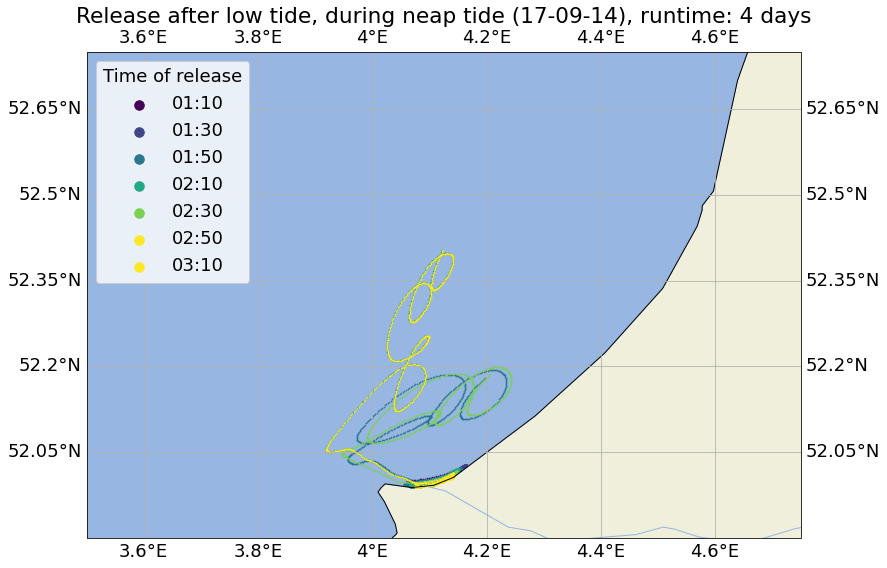

In [37]:
fig, ax = get_map()
for i in range(len(x)):
    ax.scatter(x[i], y[i], label=output.time[i,0].dt.strftime("%H:%M").values, s=0.4, color=cmap(0.2*i))
ax.legend(loc="upper left", markerscale=15, title="Time of release")
ax.set_title(f'Release after low tide, during neap tide ({output.time[0,0].dt.strftime("%d-%m-%y").values}), runtime: 4 days')

if save_plots:
    plt.gcf().savefig("../figs/sim_surface_low_tide_neap_4_days.pdf", bbox_inches="tight")